# Analysis of Ephys NWB files

In [ ]:
''' @article {R{\"u}bel2021.03.13.435173,
 author = {R{\"u}bel, Oliver and Tritt, Andrew and Ly, Ryan and Dichter, Benjamin K. and Ghosh, Satrajit and Niu, Lawrence and Soltesz, Ivan and Svoboda, Karel and Frank, Loren and Bouchard, Kristofer E.},
 title = {The Neurodata Without Borders ecosystem for neurophysiological data science},
 elocation-id = {2021.03.13.435173},
 year = {2021},
 doi = {10.1101/2021.03.13.435173},
 publisher = {Cold Spring Harbor Laboratory},
 abstract = {The neurophysiology of cells and tissues are monitored electrophysiologically and optically in diverse experiments and species, ranging from flies to humans. Understanding the brain requires integration of data across this diversity, and thus these data must be findable, accessible, interoperable, and reusable (FAIR). This requires a standard language for data and metadata that can coevolve with neuroscience. We describe design and implementation principles for a language for neurophysiology data. Our software (Neurodata Without Borders, NWB) defines and modularizes the interdependent, yet separable, components of a data language. We demonstrate NWB{\textquoteright}s impact through unified description of neurophysiology data across diverse modalities and species. NWB exists in an ecosystem which includes data management, analysis, visualization, and archive tools. Thus, the NWB data language enables reproduction, interchange, and reuse of diverse neurophysiology data. More broadly, the design principles of NWB are generally applicable to enhance discovery across biology through data FAIRness.Competing Interest StatementThe authors have declared no competing interest.},
 URL = {https://www.biorxiv.org/content/early/2021/03/15/2021.03.13.435173},
 eprint = {https://www.biorxiv.org/content/early/2021/03/15/2021.03.13.435173.full.pdf},
 journal = {bioRxiv}
} ''' 

https://pynwb.readthedocs.io/en/stable/overview_citing.html <br>
https://pynwb.readthedocs.io/en/stable/tutorials/index.html <br>
https://pynwb.readthedocs.io/en/stable/tutorials/index.html <br>
https://pynwb.readthedocs.io/en/stable/tutorials/domain/plot_icephys.html#sphx-glr-tutorials-domain-plot-icephys-py

All of this analysis is done in the [conda activate Ephys_env] envirnment as some of the packages require older versions of python, etc.

In [65]:
#%matplotlib inline
%matplotlib widget
#%matplotlib notebook
'''#TODO: create my own plotting utils'''

import numpy as np
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
#for pulling data for NWB files
import pynwb 
from pynwb.icephys import VoltageClampStimulusSeries, VoltageClampSeries
from pynwb import NWBHDF5IO
from nwbwidgets import nwb2widget
#for analysis of NWB files
from scipy import signal 
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress 
from scipy.signal import chirp, find_peaks, peak_widths
import scipy
import pandas as pd 



In [66]:
cd /Users/samgritz/Desktop/Rutgers/Milstein_Lab/Code/Ephys_Analysis/Ephys_Data 

/Users/samgritz/Desktop/Rutgers/Milstein_Lab/Code/Ephys_Analysis/Ephys_Data


## Open NWB File and create dataframe

In [67]:
io = NWBHDF5IO('20230516_CA1_BTSP_Working_Experiment-compressed.nwb', 'r', load_namespaces=True)
read_nwb_file = io.read() 

data = read_nwb_file.sweep_table.to_dataframe()
# data
#Get the data from the NWB file - the even rows are the response data and the odd rows are the stimulus data 
response_data = data.iloc[0::3] #from 0 to the end, step by 2, so get the even rows
# response_data


/opt/anaconda3/envs/Ephys_Analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/Ephys_Analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.4 because version 2.4.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/Ephys_Analysis/lib/python3.10/site-packages/hdmf/utils.py:629: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/Ephys_Analysis/lib/python3.10/site-packages/hdmf/utils.py:629: FutureWarning: Dynam

The data will have double the number of sweeps because the first sweep series data is the current stimulation (Computer to Cell - DA), then the response (Cell to Computer - AD) is second - therefore you have to divide the indexing by 2

## Using NWB widgets <br>
A potential use for this is to take data from the computer and run it through the widget to visualize which sweeps are the best <br> 
then use the NWBHDF5IO reader to plot and analyze the data <br>
https://nwb-overview.readthedocs.io/en/latest/tools/nwbwidgets/nwbwidgets.html#analysistools-nwbwidgets

In [ ]:
# nwb2widget(read_nwb_file)

In [ ]:
'''TODO: Create a pandas dataframe that contains all data needed for analysis or from experiments for example:
#Experimental metadata - maybe store as a dictionary?
- Mouse ID; phenotype
- Mouse sex
- Mouse age
- Pipette resistance
- ACSF recording solution and recording temperature
#Analysis metadata- within pandas dataframe
- Channels used for stimulation - maybe store as a dictionary?
--> electrode channels = {'channel 1': {'experiment condition' : 'LTP'}, {'biphasic stimulation amplitude' : [1000, -500]}, 
{'stimulation_time_window': np.arange(start_time*acquisition_frequency, end_time*acquisition_frequency, 1)  } 
#Analysis data - 
- experiment protocol
--> {'Baseline' : {sweep_number_range : np.arange(26,56, 1)}, 
- experiment data 
--> data = read_nwb_file.sweep_table.to_dataframe()
- acquisition_frequency 
- onset_delay  
- recording_total_time
- recording_total_points 

def get_experiment_metadata(read_nwb_file):
'''

In [68]:
acquisition_frequency = 500 #kHz
#1 kHz = 1 cycle/ms
onset_delay= round(33.3333 * acquisition_frequency)  #ms * Hz 
recording_total_time = 1500 #ms
recording_total_points = int(recording_total_time * acquisition_frequency) #ms * Hz
time = np.arange(0, recording_total_time, 1./acquisition_frequency)

[data_00094_AD0 pynwb.icephys.CurrentClampSeries at 0x140576864505088
Fields:
  comments: HS#0:Set Cycle Count: 28.00 
HS#0:Stimset Acq Cycle ID: 6512534.00 

High precision sweep start: 2023-05-16T17:47:20.218Z
TTL set cycle counts: 28;;;;;;;;

  conversion: 0.0010000000474974513
  data: <HDF5 dataset "data": shape (766667,), type "<f4">
  description: PLACEHOLDER
  electrode: electrode_0 pynwb.icephys.IntracellularElectrode at 0x140577711201712
Fields:
  description: Headstage 0
  device: device_Dev2 pynwb.device.Device at 0x140577711202192
Fields:
  description: National Instruments Model: X Series DAQ PCIe-6341 (0X742BC4C4)


  gain: 0.5
  rate: 500000.0
  resolution: nan
  starting_time: 13895469.217999935
  starting_time_unit: seconds
  stimulus_description: TTL_Empty_DA_0
  sweep_number: 94
  unit: volts
]


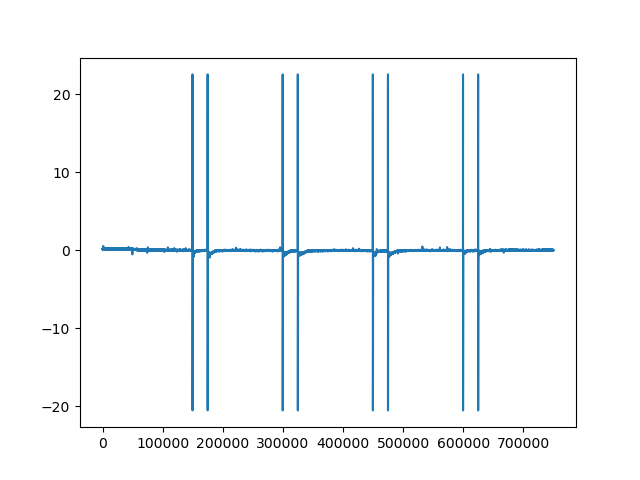

In [72]:
sweep = 94
trace_example = response_data[response_data['sweep_number']==sweep]['series']
#metadata for the trace
trace_meta = trace_example.values[0] 
print(trace_meta)

trace_example_plot = trace_example.values[0][0].data[-recording_total_points:]

offset_window = trace_example_plot[(160*acquisition_frequency):(280*acquisition_frequency)]
example_single_trace = trace_example_plot - np.mean(offset_window) 
plt.figure()
plt.plot(example_single_trace)


### Pull out data, DC offset and low pass filter

In [73]:
def offset_and_LowPass_filter(sweep_number_range, acquisition_frequency, recording_total_points, zeroing_sample_start, zeroing_sample_end, filter_order, filter_type, filter_output, low_pass_filter_frequency):
    '''This function offsets the data and applies a low pass filter to the data
    
    :param sweep_number_range: the sweep numbers to be analyzed, array of int
    :param acquisition_frequency: the sampling frequency of the data, kHz;int
    :param recording_total_points: the total number of points in the data, int
    :param zeroing_sample_start: the time point of baseline to start for offsetting the data, ms;int
    :param zeroing_sample_end: the time point of baseline to end for offsetting the data, ms;int
    :param filter_order: the order of the filter, int
    :param filter_type: the type of filter, string
    :param filter_output: the output of the filter - numerator/denominator ('ba'), pole-zero ('zpk'), or second-order sections ('sos')., string
    :param low_pass_filter_frequency: the critical frequency to filter the data, in the same units as acquisition frequency, kHz; int
    :return: filterd_offset_data
    '''
    filtered_offset_data = []
    for sweeps in sweep_number_range:
        trace = response_data[response_data['sweep_number']==sweeps]['series']
        trace_data = trace.values[0][0].data[-recording_total_points:]
        offset_window = trace_data[(zeroing_sample_start*acquisition_frequency):(zeroing_sample_end*acquisition_frequency)]
        current_trace = trace_data - np.mean(offset_window)    
        #butter(N = The order of the filter, Wn = The critical frequency or frequencies., btype='low', analog=False, output='ba', fs=The sampling frequency of the digital system.)
        #Wn is thus in half cycles / sample and defined as 2*critical frequencies / fs 
        filter = signal.butter(filter_order, (2*low_pass_filter_frequency/acquisition_frequency), filter_type, output=filter_output, fs=acquisition_frequency) 
        filtered_offset_trace = signal.sosfilt(filter, current_trace) 
        filtered_offset_data.append(filtered_offset_trace)
    return filtered_offset_data


In [74]:
#create Baseline traces
sweep_number_range = np.arange(26,56, 1)
zeroing_sample_start = 160 #ms
zeroing_sample_end = 280 #ms
filter_order = 4
filter_type = 'low'
filter_output = 'sos'
low_pass_filter_frequency = 0.02 #kHz

traces_baseline = offset_and_LowPass_filter(sweep_number_range, acquisition_frequency, recording_total_points, zeroing_sample_start, zeroing_sample_end, filter_order, filter_type, filter_output, low_pass_filter_frequency)
traces_baseline = np.array(traces_baseline)

In [75]:
traces_baseline

array([[ 6.66563637e-27,  5.98649057e-26,  2.71907072e-25, ...,
        -1.72853972e-04, -1.72855599e-04, -1.72857226e-04],
       [ 9.08722985e-27,  8.19108488e-26,  3.73750356e-25, ...,
        -9.51666571e-05, -9.51679701e-05, -9.51692830e-05],
       [ 8.62389803e-27,  7.77408636e-26,  3.54795698e-25, ...,
        -2.52025364e-04, -2.52027464e-04, -2.52029563e-04],
       ...,
       [ 8.52126760e-27,  7.66913860e-26,  3.49329812e-25, ...,
        -1.81311652e-04, -1.81313447e-04, -1.81315242e-04],
       [ 7.62122971e-27,  6.85491120e-26,  3.12176669e-25, ...,
        -2.87396556e-04, -2.87398793e-04, -2.87401030e-04],
       [ 6.32470880e-27,  5.68804292e-26,  2.58893559e-25, ...,
        -1.87947532e-04, -1.87949302e-04, -1.87951072e-04]])

In [76]:
sweep_number_range = np.arange(66,156, 1) 
zeroing_sample_start = 160 #ms
zeroing_sample_end = 280 #ms
filter_order = 4
filter_type = 'low'
filter_output = 'sos'
low_pass_filter_frequency = 0.02 #kHz

traces_LTP = offset_and_LowPass_filter(sweep_number_range, acquisition_frequency, recording_total_points, zeroing_sample_start, zeroing_sample_end, filter_order, filter_type, filter_output, low_pass_filter_frequency)
traces_LTP = np.array(traces_LTP)

In [77]:
print(traces_LTP) 

[[ 6.69044521e-27  6.01720540e-26  2.74056464e-25 ... -1.35776807e-04
  -1.35778191e-04 -1.35779576e-04]
 [ 9.32391555e-27  8.38732802e-26  3.81944810e-25 ... -4.35352760e-05
  -4.35361874e-05 -4.35370988e-05]
 [ 8.34707678e-27  7.52075379e-26  3.43068616e-25 ... -4.24990460e-05
  -4.24999992e-05 -4.25009524e-05]
 ...
 [ 1.06218044e-26  9.55962115e-26  4.35619506e-25 ... -4.87738245e-04
  -4.87741822e-04 -4.87745398e-04]
 [ 1.02783731e-26  9.24214640e-26  4.20616290e-25 ... -5.22848467e-04
  -5.22852225e-04 -5.22855983e-04]
 [ 1.06722440e-26  9.60501675e-26  4.37603657e-25 ... -4.36379911e-04
  -4.36383293e-04 -4.36386676e-04]]


array([[ 6.66563637e-27,  5.98649057e-26,  2.71907072e-25, ...,
        -1.72853972e-04, -1.72855599e-04, -1.72857226e-04],
       [ 9.08722985e-27,  8.19108488e-26,  3.73750356e-25, ...,
        -9.51666571e-05, -9.51679701e-05, -9.51692830e-05],
       [ 8.62389803e-27,  7.77408636e-26,  3.54795698e-25, ...,
        -2.52025364e-04, -2.52027464e-04, -2.52029563e-04],
       ...,
       [ 8.52126760e-27,  7.66913860e-26,  3.49329812e-25, ...,
        -1.81311652e-04, -1.81313447e-04, -1.81315242e-04],
       [ 7.62122971e-27,  6.85491120e-26,  3.12176669e-25, ...,
        -2.87396556e-04, -2.87398793e-04, -2.87401030e-04],
       [ 6.32470880e-27,  5.68804292e-26,  2.58893559e-25, ...,
        -1.87947532e-04, -1.87949302e-04, -1.87951072e-04]])

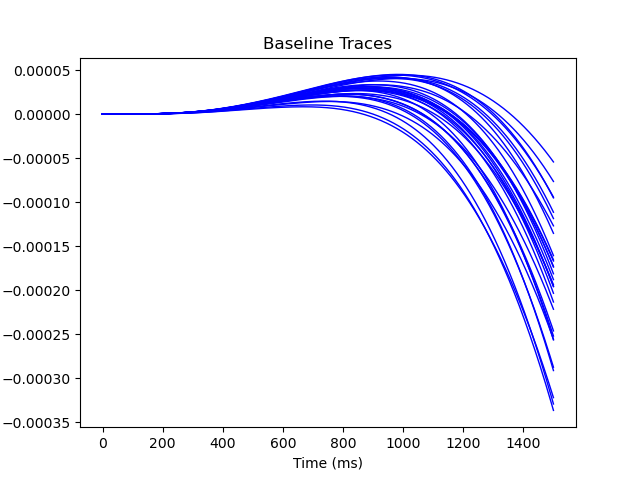

In [78]:
plt.figure()
for i in range(len(traces_baseline)):
    plt.plot(time, traces_baseline[i], color = 'blue', linewidth = 1)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Baseline Traces')
type(traces_baseline)
traces_baseline

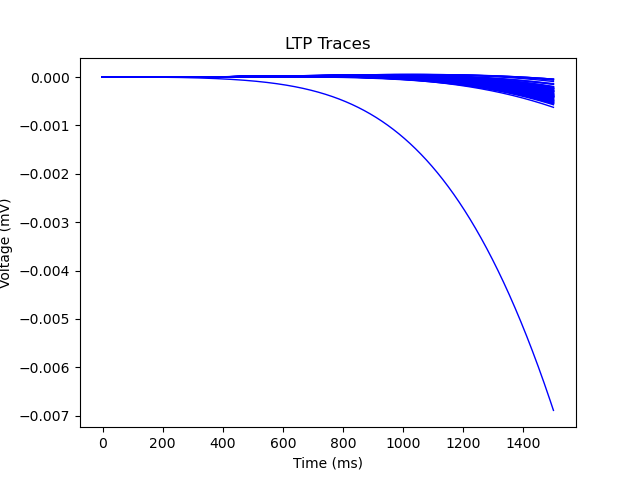

(90, 750000)


In [79]:
plt.figure()
for i in range(len(traces_LTP)):
    plt.plot(time, traces_LTP[i], color = 'blue', linewidth = 1)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('LTP Traces')
plt.show()
type(traces_LTP)
print(traces_LTP.shape)

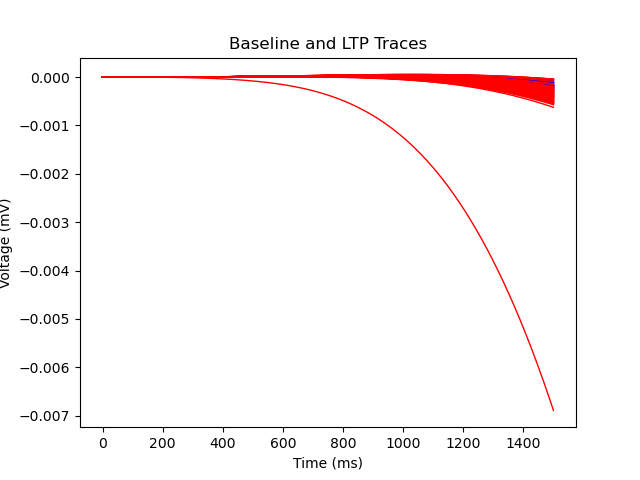

In [80]:
# data = {'baseline': traces_baseline[:], 'LTP': traces_LTP[:]}

# dataframe = pd.DataFrame(data) 
# print(dataframe)

plt.figure()
for i in range(len(traces_baseline)):
    plt.plot(time, traces_baseline[i], color = 'blue', linewidth = 1)
for i in range(len(traces_LTP)):
    plt.plot(time, traces_LTP[i], color = 'red', linewidth = 1)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Baseline and LTP Traces')
plt.show()


In [ ]:
dataframe['baseline']

In [ ]:
from scipy.interpolate import interp1d

def analyze_single_fEPSP(data, time, start_time, end_time, acquisition_frequency):    
    """
    Calculate the slope of the fEPSP within 0.6 ms window around half-max 

    Parameters
    ----------
    data : array
        fEPSP data from dataframe in mv/recording sample points
    time : array
        time data
    start_time : int
        start time of the analysis window in ms
    end_time : int
        end time of the analysis window in ms
    acquisition_frequency : int
        acquisition frequency in kHz
    y_lim_values : tuple
        y axis limits for the plot 
    x_lim_values : tuple
        x axis limits for the plot

    Returns 
    -------
    slope : float
        slope of the fEPSP
    peak_pos_time : float
        time of the peak of the fEPSP
    peak_value : float
        value of the peak of the fEPSP
    positive_artifact_time : float
        time of the peak of the stimulation artifact
    positive_artifact : float
        value of the peak of the stimulation artifact
    half_max : float
        half max value of the fEPSP
    half_max_time : float
        time of the half max value of the fEPSP

    Plotting
    -------
    analysis_time_window : array
        time window based on start and end times, or the entire window to plot the data
    analyze_window : array
        data within the analysis time window after the stim artifact
    slope_analysis_plot_window : array
        time window for the slope analysis from after the stim artifact to end
    slope_window : array
        data within that is 0.6 ms before and after the half max value
    linregress_data : array
        data within the slope window that is used for the linear regression
     data_plot : array
        data within the analysis time window to plot
    data_analyze : array
        data within the analysis time window after the stim artifact
    data_slope : array
        data within that is 0.6 ms before and after the half max value
    """
    #Define the time window for the LTP pathway
    start_time = start_time  # ms
    end_time = end_time  # ms
    #To plot LTP pathway
    analysis_time_window = np.arange(int(start_time*acquisition_frequency), int(end_time*acquisition_frequency), 1)
    data_plot = np.array(data[analysis_time_window]) 

    #To analyze the slopes after the 300 microsecond stimulation
    #inter1d function to interpolate the data to find the time of the peak
    interp_pos = interp1d(data_plot, time[analysis_time_window])
    positive_artifact_idx = find_peaks(data_plot, height = (1, 30)) 
    positive_artifact = positive_artifact_idx[1]['peak_heights'][:]  #y value of the peak
    positive_artifact_time = interp_pos(positive_artifact) #x value of the peak in ms
    # print(f'Stim artifact start time: {positive_artifact_time[0]} ms')
    analyze_window = np.arange(float(int(positive_artifact_time)+ 1.5), analysis_time_window[-1]/acquisition_frequency, 0.1) 
    analyze_window = analyze_window * acquisition_frequency 
    analyze_window  = [int(x) for x in analyze_window]

    data_analyze = np.array(data[analyze_window]) 
    fEPSP_peak_idx_baseline = find_peaks(-data_analyze, height = (0.3, 4)) 
    #this will give a peak value that is positive
    peak_value = np.max(np.abs(fEPSP_peak_idx_baseline[1]['peak_heights'][:]))  #y value of the peak
    # print(f'peak value baseline: {peak_value_baseline}')
    peak_pos_time= interp_pos(-peak_value) 
    #actual value is negative
    # print(f'peak time baseline: {peak_pos_time_baseline}')
    # print(f'peak_pos_time: {peak_pos_time}')
    # print(f'peak value: {peak_value}')

    slope_analysis_plot_window= np.arange(int(time[analyze_window[0]]*acquisition_frequency), int(peak_pos_time*acquisition_frequency), 1)
    # print(f'slope_analysis_plot: {slope_analysis_plot}')
    # print(data[slope_analysis_plot]) 
    data_slope = np.array(data[slope_analysis_plot_window]) 
    interp_pos_slope = interp1d(data_slope, time[slope_analysis_plot_window])
    half_max = -peak_value/2 
    half_max_time = interp_pos_slope(half_max)

    # print(f'half max baseline: {half_max_baseline}')
    # print(f'half max baseline time: {half_max_baseline_time}')

    #slope window is 0.6 ms around the half max
    slope_window= np.arange(int(half_max_time*acquisition_frequency)- int(0.3 * acquisition_frequency), 
                                    int(half_max_time*acquisition_frequency) + int(0.3 * acquisition_frequency), 1)

    linregress_data = linregress(time[slope_window], np.array(data[slope_window]))
    slope= abs(linregress_data[0])
    # print(f'slope: {slope}')

    return slope, peak_pos_time, peak_value, positive_artifact_time, positive_artifact, analysis_time_window, analyze_window, slope_analysis_plot_window, slope_window, linregress_data, data_plot, data_analyze, data_slope, half_max, half_max_time


In [ ]:
slope_baseline, peak_pos_time_baseline, peak_value_baseline, positive_artifact_time, positive_artifact, analysis_time_window_baseline, analyze_window_baseline, slope_analysis_plot_window_baseline, slope_window_baseline, linregress_data_baseline, data_plot_baseline, data_analyze_baseline, data_slope_baseline, half_max_baseline, half_max_time_baseline = analyze_single_fEPSP(dataframe['baseline'], time, 280, 320, acquisition_frequency) 


In [ ]:
slope_LTP, peak_pos_time_LTP, peak_value_LTP, positive_artifact_time, positive_artifact, analysis_time_window_LTP, analyze_window_LTP, slope_analysis_plot_window_LTP, slope_window_LTP, linregress_data_LTP, data_plot_LTP, data_analyze_LTP, data_slope_LTP, half_max_LTP, half_max_time_LTP= analyze_single_fEPSP(dataframe['LTP'], time, 280, 320, acquisition_frequency) 


In [ ]:
def plotting_fEPSP_slope(start_time, end_time, acquisition_frequency, dataframe, time):
    """
    """

    mpl.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['font.size'] = 12.
    mpl.rcParams['font.sans-serif'] = 'Arial'
    mpl.rcParams['text.usetex'] = False

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    fig.subplots_adjust(wspace=0.4)

    slope_baseline, peak_pos_time_baseline, peak_value_baseline, positive_artifact_time, positive_artifact, analysis_time_window_baseline, analyze_window_baseline, slope_analysis_plot_window_baseline, slope_window_baseline, linregress_data_baseline, data_plot_baseline, data_analyze_baseline, data_slope_baseline, half_max_baseline, half_max_time_baseline = analyze_single_fEPSP(data, time, start_time, end_time, acquisition_frequency) 






In [ ]:
plt.figure()
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.size'] = 12.
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['text.usetex'] = False

plt.plot(time[analysis_time_window_baseline], data_plot_baseline, color = 'black', linewidth = 1, label = 'baseline')
plt.plot(time[analysis_time_window_LTP], data_plot_LTP, color = 'red', linewidth = 1, label = 'LTP')

plt.scatter(peak_pos_time_baseline, -peak_value_baseline, c = 'black', marker = 'o', s = 50)
plt.scatter(peak_pos_time_LTP, -peak_value_LTP, c = 'red', marker = 'o', s = 50)
plt.scatter(positive_artifact_time, positive_artifact, c = 'green', marker = 'o', s = 15)

plt.plot(time[analyze_window_baseline], data_analyze_baseline, color = 'black', linewidth = 2)
plt.plot(time[analyze_window_LTP], data_analyze_LTP, color = 'red', linewidth = 2)

plt.plot(time[slope_analysis_plot_window_baseline], data_slope_baseline , color = 'black', linewidth = 2)
plt.plot(time[slope_analysis_plot_window_LTP], data_slope_LTP , color = 'red', linewidth = 2, label = f'change in slope= {(slope_LTP-slope_baseline)/slope_baseline * 100:.2f}%') 
plt.plot(time[slope_window_baseline], linregress_data_baseline[0]*time[slope_window_baseline] + linregress_data_baseline[1], linestyle= 'dashed', color = 'green', linewidth = 3, label = f'slope baseline= {slope_baseline:.2f} mV/ms')
plt.plot(time[slope_window_LTP], linregress_data_LTP[0]*time[slope_window_LTP] + linregress_data_LTP[1], linestyle= 'dashed', color = 'green', linewidth = 3, label = f'slope LTP= {slope_LTP:.2f} mV/ms')

plt.title(f'fEPSP slope analysis for LTP pathway')
plt.ylim([-1, 1])
plt.xlim(295, 310) 

plt.legend() 

In [ ]:
#control pathway
slope_baseline, peak_pos_time_baseline, peak_value_baseline, positive_artifact_time, positive_artifact, analysis_time_window_baseline, analyze_window_baseline, slope_analysis_plot_window_baseline, slope_window_baseline, linregress_data_baseline, data_plot_baseline, data_analyze_baseline, data_slope_baseline, half_max_baseline, half_max_time_baseline = analyze_single_fEPSP(dataframe['baseline'], time, 580, 620, acquisition_frequency) 
slope_LTP, peak_pos_time_LTP, peak_value_LTP, positive_artifact_time, positive_artifact, analysis_time_window_LTP, analyze_window_LTP, slope_analysis_plot_window_LTP, slope_window_LTP, linregress_data_LTP, data_plot_LTP, data_analyze_LTP, data_slope_LTP, half_max_LTP, half_max_time_LTP= analyze_single_fEPSP(dataframe['LTP'], time, 580, 620, acquisition_frequency) 

In [ ]:
plt.figure()
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.size'] = 12.
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['text.usetex'] = False

plt.plot(time[analysis_time_window_baseline], data_plot_baseline, color = 'black', linewidth = 1, label = 'baseline')
plt.plot(time[analysis_time_window_LTP], data_plot_LTP, color = 'red', linewidth = 1, label = 'LTP')

plt.scatter(peak_pos_time_baseline, -peak_value_baseline, c = 'black', marker = 'o', s = 50)
plt.scatter(peak_pos_time_LTP, -peak_value_LTP, c = 'red', marker = 'o', s = 50)
plt.scatter(positive_artifact_time, positive_artifact, c = 'green', marker = 'o', s = 15)

plt.plot(time[analyze_window_baseline], data_analyze_baseline, color = 'black', linewidth = 2)
plt.plot(time[analyze_window_LTP], data_analyze_LTP, color = 'red', linewidth = 2)

plt.plot(time[slope_analysis_plot_window_baseline], data_slope_baseline , color = 'black', linewidth = 2)
plt.plot(time[slope_analysis_plot_window_LTP], data_slope_LTP , color = 'red', linewidth = 2, label = f'change in slope= {(slope_LTP-slope_baseline)/slope_baseline * 100:.2f}%') 
plt.plot(time[slope_window_baseline], linregress_data_baseline[0]*time[slope_window_baseline] + linregress_data_baseline[1], linestyle= 'dashed', color = 'green', linewidth = 3, label = f'slope baseline= {slope_baseline:.2f} mV/ms')
plt.plot(time[slope_window_LTP], linregress_data_LTP[0]*time[slope_window_LTP] + linregress_data_LTP[1], linestyle= 'dashed', color = 'green', linewidth = 3, label = f'slope LTP= {slope_LTP:.2f} mV/ms')

plt.title(f'fEPSP slope analysis for control pathway')
plt.ylim([-1, 1])
plt.xlim(580, 620)


plt.legend() 